In [1]:
from astropy.io import fits
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import tempfile
import imageio
from scipy import signal
from importlib import reload
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pylab as pl
# super special:
import sparkles.spark as spkl
import sparkles.spark_plots as sp
lab_dir = '/home/eden/data/LAB_2023B/'

In [2]:
reload(spkl)

<module 'sparkles.spark' from '/home/eden/code/sparkles/sparkles/spark.py'>

In [3]:
# function that processess fits and saves the time series dot product as npy 
def proc_lab_data(spkl_obj, lab_dir, filename = "syncspark", workers=20, fps=2000):
    # what makes a mintue of data:
    dir_data = spkl_obj.dir_data
    data_splits_list = []
    # processing and saving the files:
    f_list = spkl_obj.file_lister(dir_data)
    n_files = len(f_list)
    n_blocks = n_files//(fps*workers)
    print(f"File count: {n_files}, Block size: {fps*workers}, Blocks: {n_blocks+1}")
    # iter over data block chunks
    for b in range(n_blocks + 1):
        ni = b*fps*workers # file number is the block number * files per worker * no of workers
        print(f"START: Block {b} starting with file {ni}!")
        data_split_s_lab = np.array(spkl.split_data_roll(np.array(spkl_obj.dot_list_pool(n_start=ni, n=fps*workers, n_workers=workers))))
        data_splits_list.append(data_split_s_lab)
        try:
            continue
        except Exception as e:
            print(f"We had an error at file {ni}!")
            print(e)
            continue
        print(f"=> END: Block {b}")
    # make sure to save this result!
    data_splits_stack = np.hstack(data_splits_list)
    file_path = f"{lab_dir}/data_splits_stack_{filename}.npy"
    np.save(file_path, data_splits_stack)
    print(f"SAVED: {file_path}")
    return data_splits_stack

In [21]:
# function that processess fits and saves the time series dot product as npy 
def proc_lab_data_roll(spkl_obj, lab_dir, filename = "syncspark", workers=20, fps=2000):
    # what makes a mintue of data:
    dir_data = spkl_obj.dir_data
    # processing and saving the files:
    f_list = spkl_obj.file_lister(dir_data)
    n_files = len(f_list)
    n_blocks = n_files//(fps*workers)
    print(f"File count: {n_files}, Block size: {fps*workers}, Blocks: {n_blocks+1}")
    # roll indicies
    data_roll_stack = []
    for i in range(4):
        # iter over data block chunks
        print(f"Start roll orientation {i}")
        data_splits_list = []
        for b in range(n_blocks + 1):
            ni = b*fps*workers # file number is the block number * files per worker * no of workers
            print(f"START: Block {b} starting with file {ni}!")
            data_split_s_lab = np.array(spkl.split_data_roll(np.array(spkl_obj.dot_list_pool(n_start=ni, n=fps*workers, n_workers=workers)), roll=i))
            data_splits_list.append(data_split_s_lab)
            try:
                continue
            except Exception as e:
                print(f"We had an error at file {ni}!")
                print(e)
                continue
            print(f"=> END: Block {b}")
        # make sure to save this result!
        data_splits_stack = np.hstack(data_splits_list)
        data_roll_stack.append(data_splits_stack)
    file_path = f"{lab_dir}/data_roll_stack_{filename}.npy"
    np.save(file_path, np.array(data_roll_stack))
    print(f"SAVED: {file_path}")
    return data_roll_stack

In [4]:
# plotting the results of reducing data
def plot_time_series(data_split_stack, file_loc, plot_name, hz = 2000, total_s = -1):
    #using the file directory to pull 
    spark_params = spkl.get_spark_params(file_loc)
    spark_param_print = " ".join([key + ':'+ str(spark_params[key]) + "," for key in spark_params])
    # set up plot
    colors = pl.cm.tab20(np.arange(4))
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,3), facecolor='white', sharex=True)
    fig.subplots_adjust(hspace=0)
    plt.suptitle(f"{plot_name} \n {spark_param_print}", y=0.99)
    #generating t axis 
    frame_n = data_split_stack.shape[1]
    if total_s == -1:
        total_s = 4*frame_n/hz
    x_axis = np.arange(0, total_s, total_s/frame_n)
    #plot each split in a complementary color
    for e in range(4):
        axs.plot(x_axis, data_split_stack[e, :], lw=2, alpha = 0.7, label = f'ref {e}', c = colors[e])
        #axs.set_ylabel(f"sparkle split {e}")
        #axs.set_ylim(bottom=0, top=0.005)
    plt.legend()
    plt.xlabel('seconds (s)')
    return plt

## OLD DATA TEST 

Processing through some old sync test data

### OLD CHECK: Sync data 22B

In [5]:
# picking the fits directories
lab_dir_old = '/home/eden/data/2022B/'
sync_22B = lab_dir_old + '12_06_spark_test_sync/camwfs/'

In [6]:
# to check sparkle parameters
#sync_22B_params = spkl.print_sparkle_params(spkl.get_spark_params(sync_22B))
# creating the sparke processing code
sp_22B_sync_spark = spkl.Spark(sync_22B, sync_22B, spkl.glob_dir_calib, spkl.glob_dark, spkl.glob_ref, spkl.glob_dark) 

HZ value: 1802
HZ value: 1802
Number of DATA files:  122895
Number of REF files:  122895
MOD : 1   TRIG : 1   FREQ : 1800   SEPS : 20   ANGS : 0   AMPS : 0.01   CROSS : 1  
MOD : 1   TRIG : 1   FREQ : 1800   SEPS : 20   ANGS : 0   AMPS : 0.01   CROSS : 1  
GENERATING REFERENCE
=> Sampling 100 files, starting at 0


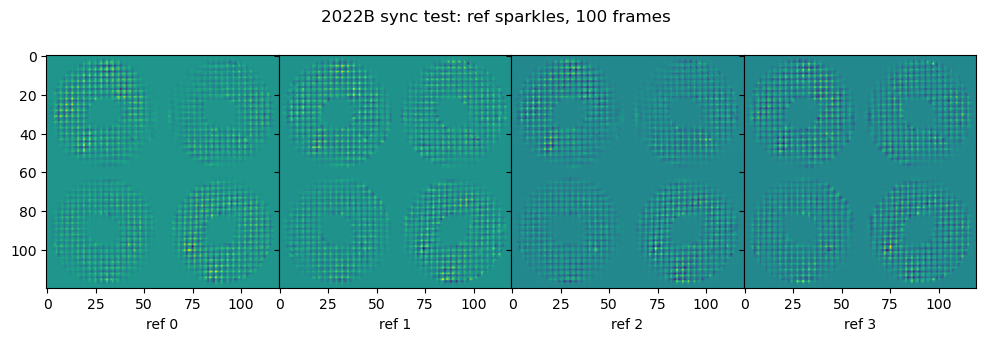

In [7]:
#checking the lab reference: 
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,4), facecolor='white', sharey=True)
fig.subplots_adjust(wspace=0)
plt.suptitle(f"2022B sync test: ref sparkles, 100 frames", y=0.90)

for e in range(4):
    axs[e].imshow(sp_22B_sync_spark.labref_norm[e], label = f'ref {e}')
    axs[e].set_xlabel(f"ref {e}")

plt.show()

In [15]:
#proc_lab_data(spkl_obj, lab_dir, filename = "syncspark", workers=20, fps=2000)
data_splits_stack_22B = proc_lab_data(sp_22B_sync_spark, lab_dir_old, filename = "sync_22B")

File count: 122895, Block size: 40000, Blocks: 4
START: Block 0 starting with file 0!
chunksize=2000, n_workers=20
START: Block 1 starting with file 40000!
chunksize=2000, n_workers=20
START: Block 2 starting with file 80000!
chunksize=2000, n_workers=20
START: Block 3 starting with file 120000!
ERROR: changing n_end to file count
chunksize=144, n_workers=20


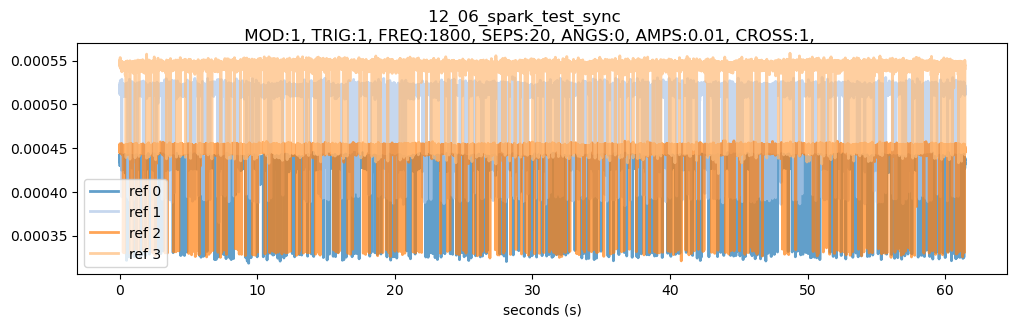

In [45]:
plot_time_series(data_splits_stack_22B, sync_22B, '12_06_spark_test_sync')
plt.show()

### OLD CHECK: UNsync data 22B

In [22]:
# picking the fits directories
lab_dir_old = '/home/eden/data/2022B/'
unsync_22B = lab_dir_old + '12_06_spark_test_unsync/camwfs/'
# creating the sparke processing code
sp_22B_unsync_spark = spkl.Spark(unsync_22B, unsync_22B, spkl.glob_dir_calib, spkl.glob_dark, spkl.glob_ref, spkl.glob_dark) 

HZ value: 1800
HZ value: 1800
Number of DATA files:  115340
Number of REF files:  115340
MOD : 1   TRIG : 1   FREQ : 1800   SEPS : 20   ANGS : 0   AMPS : 0.01   CROSS : 1  
MOD : 1   TRIG : 1   FREQ : 1800   SEPS : 20   ANGS : 0   AMPS : 0.01   CROSS : 1  
GENERATING REFERENCE
=> Sampling 100 files, starting at 0


In [23]:
# creating dot data
data_splits_stack_uns22B = proc_lab_data(sp_22B_unsync_spark, lab_dir_old, filename = "unsync_22B")

File count: 115340, Block size: 40000, Blocks: 3
START: Block 0 starting with file 0!
chunksize=2000, n_workers=20
START: Block 1 starting with file 40000!
chunksize=2000, n_workers=20
START: Block 2 starting with file 80000!
ERROR: changing n_end to file count
chunksize=1767, n_workers=20


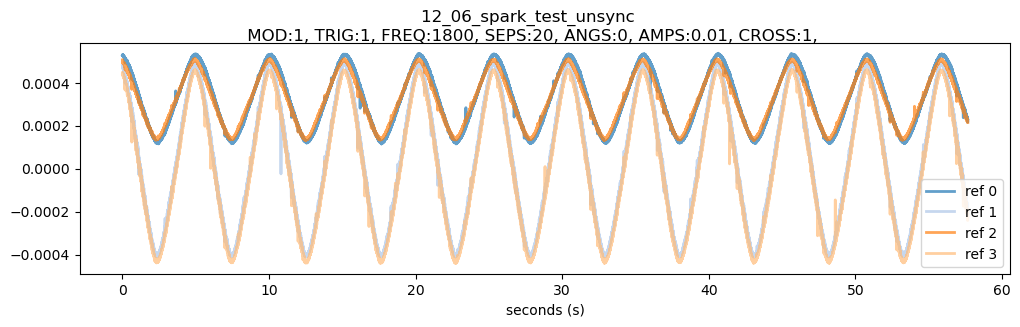

In [46]:
plot_time_series(data_splits_stack_uns22B, unsync_22B, '12_06_spark_test_unsync')
plt.show()

# LAB TESTS: REDO 

Initial lab tests had issues because the system wasn't calibrated (modulator I think?)

## Synced

##### Dark gen testing

In [25]:
reload(spkl)

<module 'sparkles.spark' from '/home/eden/code/sparkles/sparkles/spark.py'>

In [5]:
# Making a new dark, setting it to the sparkles dir
# this is what we'll use to name the dark
sync_23B_dark = 'sync_sparkles_1khz_dark_20231221T220206'
# this is what we'll use to find the dark
sync_23B_dark_path = lab_dir + sync_23B_dark + '/camwfs/'

In [41]:
sp_23B_sync_spark.set_dark(sync_23B_dark, sync_23B_dark_path, n_dark=100)

Found saved lab ref at:  /home/eden/data/calib/dark_sync_sparkles_1khz_dark_20231221T220206.fits
Recalculate Lab Ref
GENERATING REFERENCE
=> Sampling 100 files, starting at 0


##### Sync results

In [6]:
# picking the fits directories
lab_dir = '/home/eden/data/LAB_2023B/'
sync_23B = lab_dir + 'synd_sparkles_1khz_20231221T220804/camwfs/'
sync_23B_dark = 'dark_sync_sparkles_1khz_dark_20231221T220206.fits' #HAVE TO GEN THIS
# creating the sparke processing code
sp_23B_sync_spark = spkl.Spark(sync_23B, sync_23B, spkl.glob_dir_calib, sync_23B_dark, spkl.glob_ref, spkl.glob_dark) 

HZ value: 2000
HZ value: 2000
Number of DATA files:  308407
Number of REF files:  308407
MOD : 1   TRIG : 1   FREQ : 2000   SEPS : 20   ANGS : 0   AMPS : 0.03   CROSS : 1  
MOD : 1   TRIG : 1   FREQ : 2000   SEPS : 20   ANGS : 0   AMPS : 0.03   CROSS : 1  
GENERATING REFERENCE
=> Sampling 100 files, starting at 0


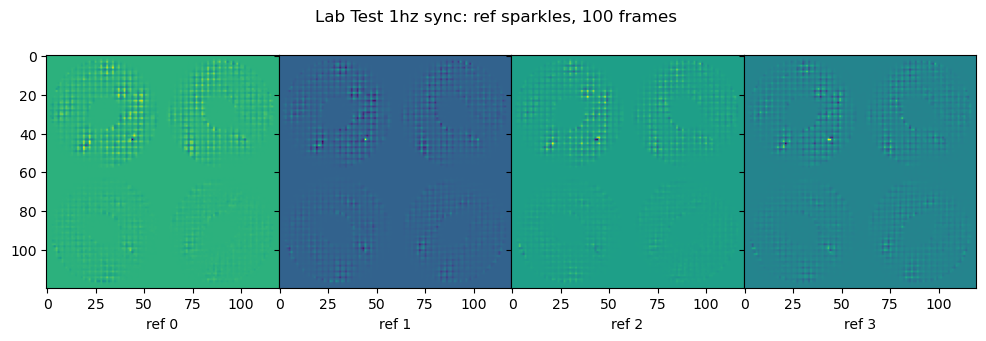

In [39]:
#checking the lab reference: 
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,4), facecolor='white', sharey=True)
fig.subplots_adjust(wspace=0)
plt.suptitle(f"Lab Test 1hz sync: ref sparkles, 100 frames", y=0.90)

for e in range(4):
    axs[e].imshow(sp_23B_sync_spark.labref_norm[e], label = f'ref {e}')
    axs[e].set_xlabel(f"ref {e}")

In [10]:
# creating dot data
data_splits_stack_s23B = proc_lab_data(sp_23B_sync_spark, lab_dir, filename = "sync_23B")

File count: 308407, Block size: 40000, Blocks: 8
START: Block 0 starting with file 0!
chunksize=2000, n_workers=20
START: Block 1 starting with file 40000!
chunksize=2000, n_workers=20
START: Block 2 starting with file 80000!
chunksize=2000, n_workers=20
START: Block 3 starting with file 120000!
chunksize=2000, n_workers=20
START: Block 4 starting with file 160000!
chunksize=2000, n_workers=20
START: Block 5 starting with file 200000!
chunksize=2000, n_workers=20
START: Block 6 starting with file 240000!
chunksize=2000, n_workers=20
START: Block 7 starting with file 280000!
ERROR: changing n_end to file count
chunksize=1420, n_workers=20
SAVED: /home/eden/data/LAB_2023B//data_splits_stack_sync_23B.npy


In [7]:
# load this series you dummy
data_splits_stack_s23B = np.load(lab_dir + 'data_splits_stack_sync_23B.npy')


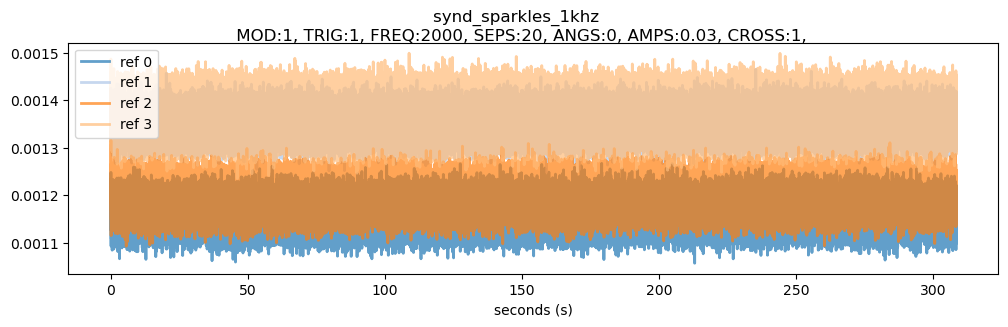

In [8]:
plot_time_series(data_splits_stack_s23B, sync_23B, 'synd_sparkles_1khz',  hz = 1000)
plt.show()

In [19]:
def plot_time_series_smoothed(data_split_stack, file_loc, plot_name, n_avg = 1000, hz = 2000, total_s = -1):
    #using the file directory to pull 
    spark_params = spkl.get_spark_params(file_loc)
    spark_param_print = " ".join([key + ':'+ str(spark_params[key]) + "," for key in spark_params])
    
    #generating t axis 
    frame_n = data_split_stack.shape[1]
    if total_s == -1:
        total_s = 4*frame_n/hz
    x_axis = np.arange(0, total_s, total_s*n_avg/frame_n)
    #calculate the roling values:
    dot_avgs, dot_stds = spkl.return_rolling(data_split_stack, n=n_avg)
    # set up plot
    colors = pl.cm.tab20(np.arange(4))
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,3), facecolor='white', sharex=True)
    fig.subplots_adjust(hspace=0)
    plt.suptitle(f"{plot_name} \n {spark_param_print}", y=0.99)
    #plot each split in a complementary color
    for e in range(4):
        dot_avgs, dot_stds = spkl.return_rolling(data_split_stack[e], n=n_avg)
        axs.fill_between(np.arange(dot_avgs.shape[0]), dot_avgs-dot_stds, dot_avgs+dot_stds, alpha=0.2, color = colors[e])
        axs.plot(dot_avgs, lw=2, label = f'split {e}, LAB', color = colors[e])
    axs.set_ylim(bottom=0, top=np.max(data_split_stack))
    plt.legend()
    plt.xlabel('seconds (s)')
    return plt

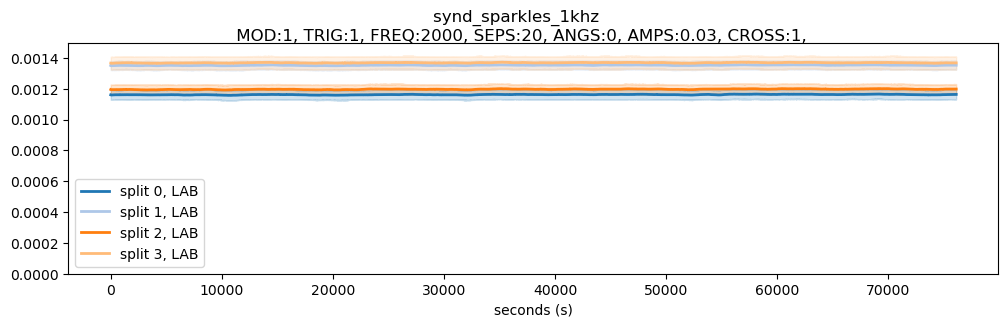

In [20]:
plot_time_series_smoothed(data_splits_stack_s23B, sync_23B, 'synd_sparkles_1khz', n_avg = 1000, hz = 1000)
plt.show()

In [22]:
# want to check the roll on dot data
data_roll_stack_s23B = proc_lab_data_roll(sp_23B_sync_spark, lab_dir, filename = "sync_23B")

File count: 308407, Block size: 40000, Blocks: 8
Start roll orientation 0
START: Block 0 starting with file 0!
chunksize=2000, n_workers=20
START: Block 1 starting with file 40000!
chunksize=2000, n_workers=20
START: Block 2 starting with file 80000!
chunksize=2000, n_workers=20
START: Block 3 starting with file 120000!
chunksize=2000, n_workers=20
START: Block 4 starting with file 160000!
chunksize=2000, n_workers=20
START: Block 5 starting with file 200000!
chunksize=2000, n_workers=20
START: Block 6 starting with file 240000!
chunksize=2000, n_workers=20
START: Block 7 starting with file 280000!
ERROR: changing n_end to file count
chunksize=1420, n_workers=20
Start roll orientation 1
START: Block 0 starting with file 0!
chunksize=2000, n_workers=20
START: Block 1 starting with file 40000!
chunksize=2000, n_workers=20
START: Block 2 starting with file 80000!
chunksize=2000, n_workers=20
START: Block 3 starting with file 120000!
chunksize=2000, n_workers=20
START: Block 4 starting wit

In [ ]:
# load this series you dummy, once you've made it
data_roll_stack_s23B = np.load(lab_dir + 'data_roll_stack_sync_23B.npy')

In [ ]:
def plot_time_series_roll_smoothed(data_roll_stack, file_loc, plot_name, n_avg = 1000, hz = 2000, total_s = -1):
    #using the file directory to pull 
    spark_params = spkl.get_spark_params(file_loc)
    spark_param_print = " ".join([key + ':'+ str(spark_params[key]) + "," for key in spark_params])
    
    #generating t axis 
    frame_n = data_split_stack.shape[1]
    if total_s == -1:
        total_s = 4*frame_n/hz
    x_axis = np.arange(0, total_s, total_s*n_avg/frame_n)
    #calculate the roling values:
    dot_avgs, dot_stds = spkl.return_rolling(data_split_stack, n=n_avg)
    # set up plot
    colors = pl.cm.tab20(np.arange(4))
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,3), facecolor='white', sharex=True)
    fig.subplots_adjust(hspace=0)
    plt.suptitle(f"{plot_name} \n {spark_param_print}", y=0.99)
    #plot each split in a complementary color
    for e in range(4):
        dot_avgs, dot_stds = spkl.return_rolling(data_split_stack[e], n=n_avg)
        axs.fill_between(np.arange(dot_avgs.shape[0]), dot_avgs-dot_stds, dot_avgs+dot_stds, alpha=0.2, color = colors[e])
        axs.plot(dot_avgs, lw=2, label = f'split {e}, LAB', color = colors[e])
    axs.set_ylim(bottom=0, top=np.max(data_split_stack))
    plt.legend()
    plt.xlabel('seconds (s)')
    return plt

In [ ]:
# should do a roll, so see if we can tell the difference between different sparkle references

## unsync

In [56]:
reload(spkl)
# picking the fits directories
lab_dir = '/home/eden/data/LAB_2023B/'
unsync_23B = lab_dir + 'unsync_sparkles_1khz_20231221T214447/camwfs/'
# creating the sparke processing code
sp_23B_unsync_spark = spkl.Spark(unsync_23B, unsync_23B, spkl.glob_dir_calib, spkl.glob_dark, spkl.glob_ref, spkl.glob_dark) 

HZ value: 1000
HZ value: 1000
Number of DATA files:  1110819
Number of REF files:  1110819
MOD : 1   TRIG : 1   FREQ : 2000   SEPS : 20   ANGS : 0   AMPS : 0.03   CROSS : 1  
MOD : 1   TRIG : 1   FREQ : 2000   SEPS : 20   ANGS : 0   AMPS : 0.03   CROSS : 1  
GENERATING REFERENCE
=> Sampling 100 files, starting at 0


#### Testing Darks

In [48]:
# TODO: making a new dark?
unsync_23B_dark = 'unsync_sparkles_1khz_dark_20231221T213710'
# this is what we'll use to find the dark
unsync_23B_dark_path = lab_dir + unsync_23B_dark + '/camwfs/'

In [49]:
sp_23B_unsync_spark.set_dark(unsync_23B_dark, unsync_23B_dark_path, n_dark=100)

GENERATING DARK
SAVING DARK
SAVED:  /home/eden/data/LAB_2023B/unsync_sparkles_1khz_dark_20231221T213710/dark_unsync_sparkles_1khz_dark_20231221T213710.fits
SAVED:  /home/eden/data/calib/dark_unsync_sparkles_1khz_dark_20231221T213710.fits
Recalculate Lab Ref
GENERATING REFERENCE
=> Sampling 100 files, starting at 0


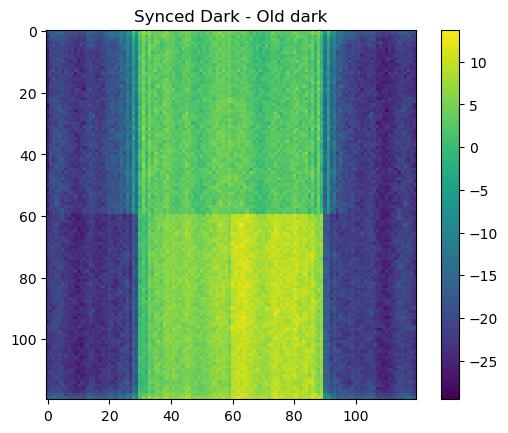

In [57]:
# Plotting the dark data:
plt.title("Synced Dark - Old dark")
plt.imshow(sp_23B_sync_spark.dark_data - sp_23B_unsync_spark.dark_data)
plt.colorbar()
plt.show()


In [8]:
# look at how the reference is made
# can probably do the same thing, just be more careful 

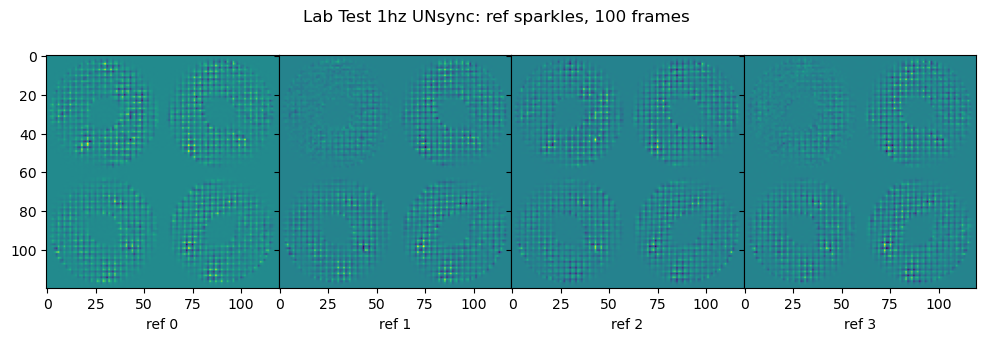

In [51]:
#checking the lab reference: 
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,4), facecolor='white', sharey=True)
fig.subplots_adjust(wspace=0)
plt.suptitle(f"Lab Test 1hz UNsync: ref sparkles, 100 frames", y=0.90)

for e in range(4):
    axs[e].imshow(sp_23B_unsync_spark.labref_norm[e], label = f'ref {e}')
    axs[e].set_xlabel(f"ref {e}")

In [31]:
# creating dot data
data_splits_stack_uns23B = proc_lab_data(sp_23B_unsync_spark, lab_dir, filename = "unsync_23B")

File count: 1110819, Block size: 40000, Blocks: 28
START: Block 0 starting with file 0!
chunksize=2000, n_workers=20
START: Block 1 starting with file 40000!
chunksize=2000, n_workers=20
START: Block 2 starting with file 80000!
chunksize=2000, n_workers=20
START: Block 3 starting with file 120000!
chunksize=2000, n_workers=20
START: Block 4 starting with file 160000!
chunksize=2000, n_workers=20
START: Block 5 starting with file 200000!
chunksize=2000, n_workers=20
START: Block 6 starting with file 240000!
chunksize=2000, n_workers=20
START: Block 7 starting with file 280000!
chunksize=2000, n_workers=20
START: Block 8 starting with file 320000!
chunksize=2000, n_workers=20
START: Block 9 starting with file 360000!
chunksize=2000, n_workers=20
START: Block 10 starting with file 400000!
chunksize=2000, n_workers=20
START: Block 11 starting with file 440000!
chunksize=2000, n_workers=20
START: Block 12 starting with file 480000!
chunksize=2000, n_workers=20
START: Block 13 starting with 

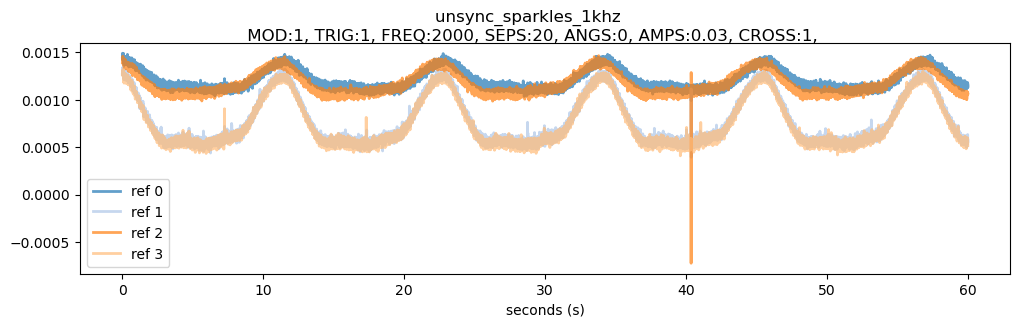

In [48]:
plot_time_series(data_splits_stack_uns23B[:, :15000], unsync_23B, 'unsync_sparkles_1khz', hz = 1000, total_s = 60)
plt.show()

# LAB TESTS:

First set of lab tests are loooking at a sparkle data set  (0.1 ao, 15 sep, synchoniation on, loop off) to test the new synchronization between the modulator and the WFS

In [2]:
sync_spark = lab_dir + "sparkle_synch_test_20231218T201512/camwfs/"
spark_params = spkl.print_sparkle_params(spkl.get_spark_params(sync_spark))

MOD : 1   TRIG : 1   FREQ : 2000   SEPS : 15   ANGS : 0   AMPS : 0.01   CROSS : 1  


In [3]:
# creating the sparke processing code
sp_lab_sync_spark = spkl.Spark(sync_spark, sync_spark, spkl.glob_dir_calib, spkl.glob_dark, spkl.glob_ref, spkl.glob_dark) 

HZ value: 3623
HZ value: 3623
Number of DATA files:  204167
Number of REF files:  204167
MOD : 1   TRIG : 1   FREQ : 2000   SEPS : 15   ANGS : 0   AMPS : 0.01   CROSS : 1  
MOD : 1   TRIG : 1   FREQ : 2000   SEPS : 15   ANGS : 0   AMPS : 0.01   CROSS : 1  
GENERATING REFERENCE
=> Sampling 100 files, starting at 0


In [34]:
sp_lab_sync_spark.set_lab_ref(n_lab = 400, n_start = 0)

GENERATING REFERENCE
=> Sampling 400 files, starting at 0


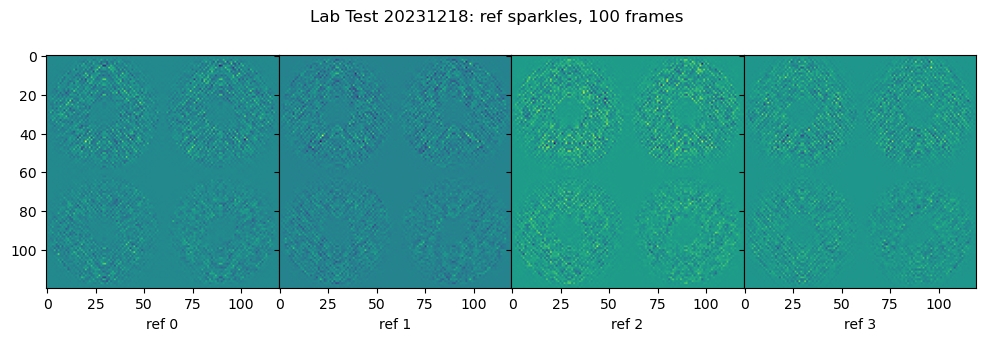

In [35]:
#checking the lab reference: 
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,4), facecolor='white', sharey=True)
fig.subplots_adjust(wspace=0)
plt.suptitle(f"Lab Test 20231218: ref sparkles, 100 frames", y=0.90)

for e in range(4):
    axs[e].imshow(sp_lab_sync_spark.labref_norm[e], label = f'ref {i}')
    axs[e].set_xlabel(f"ref {e}")

plt.show()

In [36]:
# processing and saving the files:
f_list_lab_spark = sp_lab_sync_spark.file_lister(sp_lab_sync_spark.dir_data)
print(len(f_list_lab_spark))

# what makes a mintue of data:
dir_data = sp_lab_sync_spark.dir_data
data_splits_list = []

workers = 20
fps = 2000

for n in range(len(f_list_lab_spark)//(fps*workers)):
    ni = n*fps*workers
    print(f"START: Block {n} starting with file {ni}!")
    try:
        data_split_s_lab = np.array(spkl.split_data_roll(np.array(sp_lab_sync_spark.dot_list_pool(n_start=ni, n=fps*workers, n_workers=workers))))
        data_splits_list.append(data_split_s_lab)
    except Exception as e:
        print(f"We had an error at file {ni}!")
        continue
    print(f"=> END: Block {n}")

# make sure to save this result!
np.save(f"{lab_dir}/data_splits_list_syncspark.npy", data_splits_list)

204167
START: Block 0 starting with file 0!
chunksize=2000, n_workers=20
=> END: Block 0
START: Block 1 starting with file 40000!
chunksize=2000, n_workers=20
=> END: Block 1
START: Block 2 starting with file 80000!
chunksize=2000, n_workers=20
=> END: Block 2
START: Block 3 starting with file 120000!
chunksize=2000, n_workers=20
=> END: Block 3
START: Block 4 starting with file 160000!
chunksize=2000, n_workers=20
=> END: Block 4


In [37]:
# Pulling saved dot product
data_splits_list_syncspark = np.load(f"{lab_dir}/data_splits_list_syncspark.npy")
data_splits_list_syncspark.shape

(5, 4, 10000)

In [38]:
# stacking the splits to then print
data_splits_stack_syncspark = np.hstack(data_splits_list_syncspark)
data_splits_stack_syncspark.shape

(4, 50000)

Text(0.5, 0, 'seconds (s)')

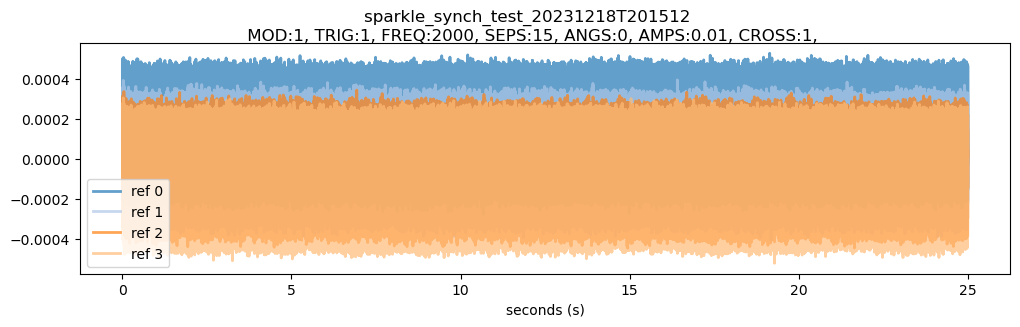

In [43]:
lab_file = 'sparkle_synch_test_20231218T201512'

spark_params = spkl.get_spark_params(sync_spark)
spark_param_print = " ".join([key + ':'+ str(spark_params[key]) + "," for key in spark_params])

colors = pl.cm.tab20(np.arange(4))
# set up plot
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,3), facecolor='white', sharex=True)
fig.subplots_adjust(hspace=0)
plt.suptitle(f"{lab_file} \n {spark_param_print}", y=0.99)

#generating t axis 
hz = 2000
frame_n = data_splits_stack_syncspark.shape[1]
total_s = frame_n/hz
x_axis = np.arange(0, total_s, total_s/frame_n)

for e in range(4):
    axs.plot(x_axis, data_splits_stack_syncspark[e, :], lw=2, alpha = 0.7, label = f'ref {e}', c = colors[e])
    #axs.set_ylabel(f"sparkle split {e}")
    #axs.set_ylim(bottom=0, top=0.005)

plt.legend()
plt.xlabel('seconds (s)')

## Processing dark:


In [25]:
sync_dark = lab_dir + "sparkle_synch_test_20231218T201724/camwfs/"

In [26]:
# creating the sparke processing code
sp_lab_sync_dark = spkl.Spark(sync_dark, sync_dark, spkl.glob_dir_calib, spkl.glob_dark, spkl.glob_ref, spkl.glob_dark) #skipping bc FREQ

HZ value: 3623
HZ value: 3623
Number of DATA files:  30546
Number of REF files:  30546
MOD : 1   TRIG : 1   FREQ : 2000   SEPS : 15   ANGS : 0   AMPS : 0.01   CROSS : 1  
MOD : 1   TRIG : 1   FREQ : 2000   SEPS : 15   ANGS : 0   AMPS : 0.01   CROSS : 1  
GENERATING REFERENCE
=> Sampling 100 files, starting at 0
